In [1]:
conda install -c conda-forge shap


Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Natal\anaconda3

  added / updated specs:
    - shap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-3.0.13             |       h2bbff1b_2         7.5 MB
    shap-0.42.1                |  py311hf62ec03_0         753 KB
    slicer-0.0.7               |     pyhd3eb1b0_0          18 KB
    ------------------------------------------------------------
                                           Total:         8.2 MB

The following NEW packages will be INSTALLED:

  shap               pkgs/main/win-64::shap-0.42.1-py311hf62ec03_0 
  slicer             pkgs/main/noarch::slicer-0.0.7-pyhd3eb1b0_0 

The following packages will be UPDATED:

  openssl                                 3.0.13-h2bbff1b_1 --> 3.0.13-h2bbff1b_2 




slicer-0.0.7         | 18 KB    



==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.5.0




In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_validate, GridSearchCV, train_test_split, cross_val_score


import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

df_normal_quality = pd.read_csv('df_normal_quality.csv', index_col=0)
y = df_normal_quality.SalePrice
X = df_normal_quality.drop(['SalePrice', 'PID'], axis =1).copy()

In [224]:
numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)
#categorical_preprocessor = OneHotEncoder(handle_unknown="ignore", drop='first')
categorical_preprocessor =  OrdinalEncoder(handle_unknown="use_encoded_value", 
                                          unknown_value= -1)


numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer(
    [
        ("standard_scaler", numerical_preprocessor, numerical_columns),
        ("encoder", categorical_preprocessor, categorical_columns),
    ]
)

# xgb =  XGBRegressor(max_depth = 2, learning_rate = 0.03948737640519406,
#                    subsample = 0.3203617673528298, colsample_bytree =0.9678010901635519,
#                    min_child_weight = 2)

xgb =  XGBRegressor(n_estimators = 1000, max_depth = 2, learning_rate = 0.03948737640519406,
                    subsample = 0.3203617673528298, colsample_bytree =0.9678010901635519,
                    min_child_weight = 2)

xgb_pipe = Pipeline(steps=[("Preprocess", preprocessor), ("XGB", xgb)])

#xgb_regr = TransformedTargetRegressor(regressor= xgb_pipe,
                                             #    func=np.log, inverse_func=np.exp)

# param_grid = {
#     "regressor__XGB__max_depth": [3],
#     "regressor__XGB__learning_rate": [0.03948737640519406],
#     "regressor__XGB__subsample": [0.3203617673528298],
#     "regressor__XGB__colsample_bytree": [0.9678010901635519],
#     "regressor__XGB__n_estimators": [1000],
#     "regressor__XGB__min_child_weight": [2]
# }

param_grid = {
    "XGB__max_depth": [3],
    "XGB__learning_rate": [0.03948737640519406],
    "XGB__subsample": [0.3203617673528298],
    "XGB__colsample_bytree": [0.9678010901635519],
    "XGB__n_estimators": [1000],
    "XGB__min_child_weight": [2]
}

xgb_search = GridSearchCV(xgb_pipe, param_grid, n_jobs=2, cv = kf)

In [225]:
xgb_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('Preprocess',
                                        ColumnTransformer(transformers=[('standard_scaler',
                                                                         StandardScaler(),
                                                                         ['GrLivArea',
                                                                          'MSSubClass',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'Alley',
                                                                          'LotShape',
                                                                          'LandContour',
                                                                          'Utilities',
                                                                          'LandSlope',
                                                                          'OverallQual',
                                                                          'OverallCond',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'MasVnrArea',
                                                                          'Ext...
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=1000,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             n_jobs=2,
             param_grid={'XGB__colsample_bytree': [0.9678010901635519],
                         'XGB__learning_rate': [0.03948737640519406],
                         'XGB__max_depth': [3], 'XGB__min_child_weight': [2],
                         'XGB__n_estimators': [1000],
                         'XGB__subsample': [0.3203617673528298]})

In [226]:
print(xgb_search.best_score_)
print(xgb_search.best_params_)

0.95184668642212
{'XGB__colsample_bytree': 0.9678010901635519, 'XGB__learning_rate': 0.03948737640519406, 'XGB__max_depth': 3, 'XGB__min_child_weight': 2, 'XGB__n_estimators': 1000, 'XGB__subsample': 0.3203617673528298}


In [24]:
X_scale = preprocessor.fit_transform(X)
X_scale

array([[-1.31047612, -0.65723049, -0.27116347, ...,  4.        ,
         8.        ,  0.        ],
       [-0.8920751 ,  1.42372685, -0.86919287, ...,  4.        ,
         8.        ,  0.        ],
       [-0.99613338, -0.65723049, -0.34339947, ...,  4.        ,
         8.        ,  0.        ],
       ...,
       [ 1.17391542,  0.7300744 ,  0.29923692, ...,  4.        ,
         8.        ,  0.        ],
       [ 0.82705447,  0.03642196, -0.05467572, ...,  4.        ,
         8.        ,  0.        ],
       [ 0.97663825,  0.03642196,  0.24081543, ...,  4.        ,
         8.        ,  0.        ]])

In [185]:
xgb.fit(X_scale, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9678010901635519, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03948737640519406,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [186]:
xgb.predict(X_scale)

array([127632.48, 136876.7 , 122253.04, ..., 148305.64, 222114.31,
       222939.08], dtype=float32)

In [9]:
xgb_search.fit(X, y)
print(xgb_search.best_score_)
print(xgb_search.best_params_)

0.95184668642212
{'XGB__colsample_bytree': 0.9678010901635519, 'XGB__learning_rate': 0.03948737640519406, 'XGB__max_depth': 3, 'XGB__min_child_weight': 2, 'XGB__n_estimators': 1000, 'XGB__subsample': 0.3203617673528298}


In [58]:
numerical_columns_selector(X)

['GrLivArea',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LandSlope',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolQC',
 'MoSold',
 'YrSold',
 'Bathrooms']

In [35]:
predictions

array([125011.41 , 134832.44 , 120605.305, ..., 147615.33 , 224246.8  ,
       213646.95 ], dtype=float32)

In [67]:
categorical_columns_selector(X)

['MSZoning',
 'Street',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'CentralAir',
 'Electrical',
 'GarageType',
 'GarageYN',
 'PoolYN',
 'Fence',
 'SaleType',
 'SaleCondition']

In [69]:
original_names = numerical_columns_selector(X) + categorical_columns_selector(X)

In [89]:
X.shape

(2333, 78)

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size=.75, random_state= 150)

X_train_scale =preprocessor.fit_transform(X_train)

X_test_scale = preprocessor.fit_transform(X_test)

xgb.fit(X_train_scale, y_train)

xgb.score(X_test_scale, y_test)

0.9277056795528565

In [219]:
X_train = X_train.reset_index(drop = True)

In [220]:
X_train

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,3SsnPorch,ScreenPorch,PoolYN,PoolQC,Fence,MoSold,YrSold,SaleType,SaleCondition,Bathrooms
0,1216,120,RM,32.000000,4500,Pave,0.0,1,4,4,...,0,0,no,0.0,NO,5,2006,WD,Normal,3.0
1,1442,20,RL,114.000000,10357,Pave,0.0,2,4,4,...,0,0,no,0.0,NO,5,2007,WD,Normal,3.0
2,1524,20,RL,82.000000,20270,Pave,0.0,2,4,4,...,0,0,no,0.0,NO,4,2008,WD,Normal,3.0
3,1360,80,RL,60.000000,7134,Pave,0.0,1,3,4,...,0,0,no,0.0,MnPrv,2,2007,WD,Normal,1.0
4,924,50,RL,60.000000,8064,Pave,0.0,1,4,4,...,0,0,no,0.0,MnPrv,7,2007,WD,Normal,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744,1742,120,RL,51.965755,6563,Pave,0.0,2,1,4,...,0,0,no,0.0,NO,12,2006,WD,Normal,3.0
1745,912,20,RL,61.689045,7791,Pave,0.0,2,4,4,...,0,0,no,0.0,GdWo,10,2009,WD,Normal,2.0
1746,1086,20,RL,85.000000,10200,Pave,0.0,1,4,4,...,0,0,no,0.0,GdWo,5,2010,WD,Normal,2.0
1747,2046,20,RL,105.000000,15431,Pave,0.0,1,4,4,...,0,175,no,0.0,NO,8,2007,WD,Normal,3.5


In [231]:
X_train.loc[X_train.OverallQual < 30].OverallQual

3       25
4       25
5       25
13      25
14      25
        ..
1740    25
1741    25
1743    25
1745    25
1746    25
Name: OverallQual, Length: 678, dtype: int64

In [227]:
scores = cross_val_score(xgb, X_scale, y, cv = kf, error_score='raise')
scores.mean()

0.9479550259985275

In [192]:
xgb.fit(X_train, y_train)

predictions = xgb.predict(X_test)

explainer = shap.Explainer(xgb, feature_names= original_names)
sv = explainer(X_train)

exp = Explanation(sv, sv.base_values, X_train, feature_names= original_names)
#exp = Explanation(sv[])
#waterfall_plot(sv)

In [256]:
sv.values

array([[-1.0703766e+04, -9.0073907e+02, -2.0120889e+02, ...,
        -8.0226021e+00,  0.0000000e+00,  0.0000000e+00],
       [-7.5401772e+03, -2.0268549e+02,  4.5455643e+02, ...,
         1.1342373e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.7755719e+03, -3.1565930e+02,  1.5187959e+03, ...,
        -8.0226021e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-1.2554402e+04, -1.1571822e+02,  9.7934119e+02, ...,
         2.2476649e+02,  0.0000000e+00,  0.0000000e+00],
       [ 2.5280166e+04, -3.9410999e+02,  7.8391826e+03, ...,
         1.1342373e+00,  0.0000000e+00,  0.0000000e+00],
       [ 8.0693589e+03, -2.6042987e+02,  1.9231541e+02, ...,
        -8.0226021e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [255]:
sv.base_values

array([172908.8, 172908.8, 172908.8, ..., 172908.8, 172908.8, 172908.8],
      dtype=float32)

In [253]:
type(exp)

shap._explanation.Explanation

In [250]:
X_train.loc[X_train.OverallQual == 9].OverallQual

37      9
40      9
146     9
147     9
179     9
216     9
268     9
321     9
345     9
381     9
408     9
450     9
479     9
713     9
873     9
992     9
1355    9
1401    9
1406    9
1428    9
1454    9
1498    9
1640    9
1673    9
Name: OverallQual, dtype: int64

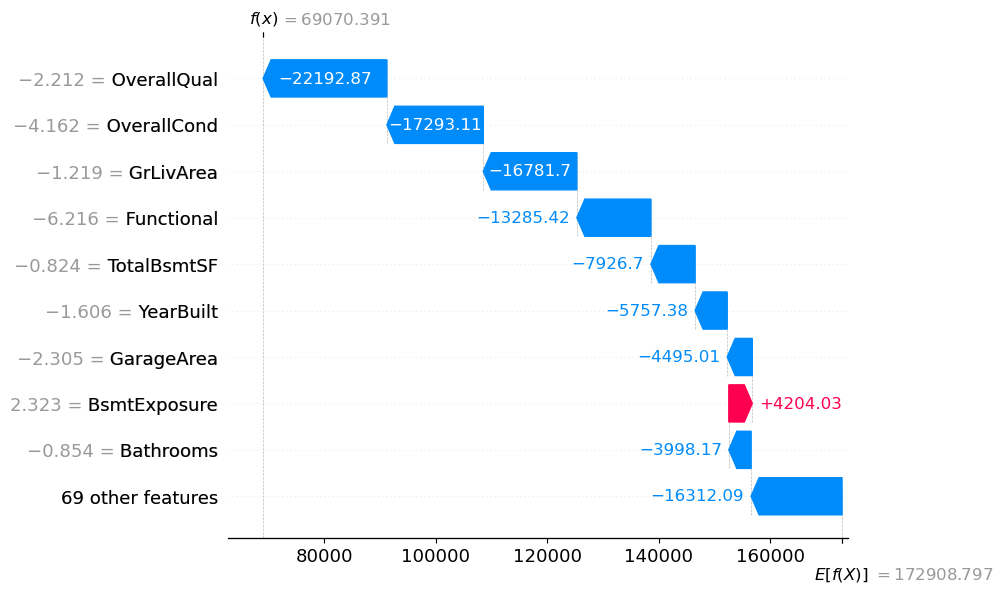

In [251]:
# quality of 1
shap.waterfall_plot(exp[244])

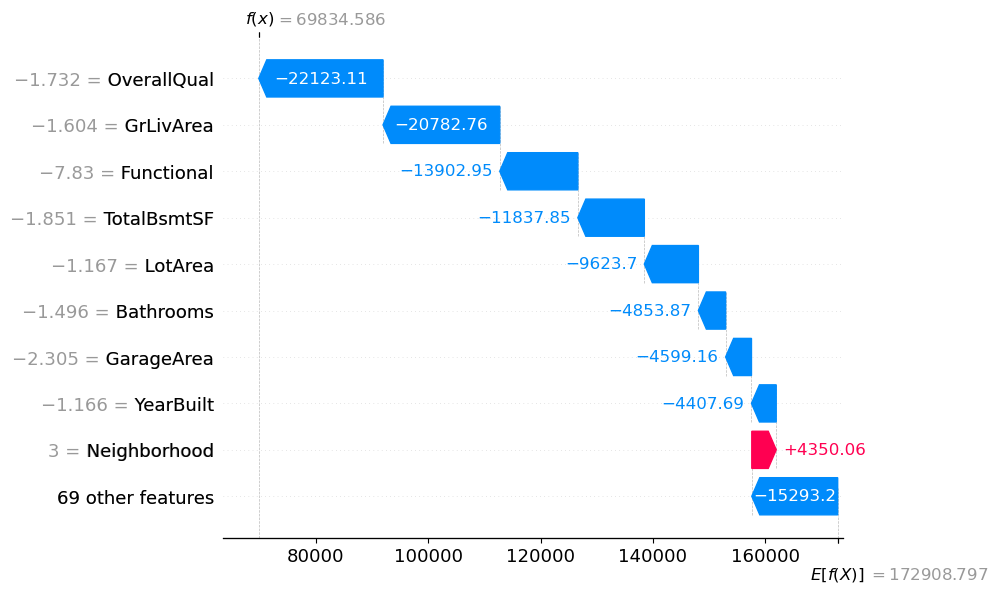

In [252]:
# quality of 3
shap.waterfall_plot(exp[1454])

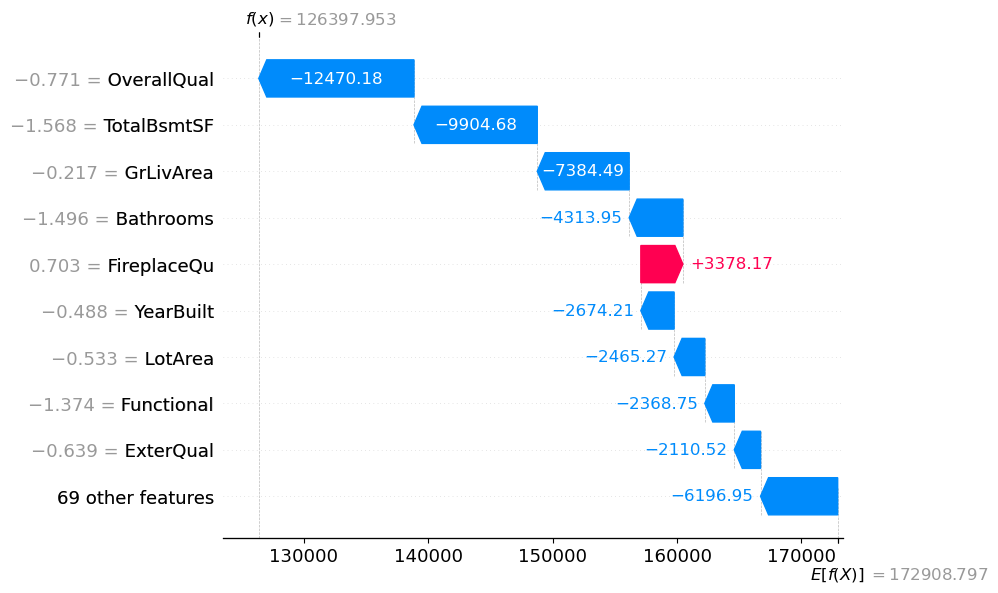

In [246]:
# quality of 5
shap.waterfall_plot(exp[3])

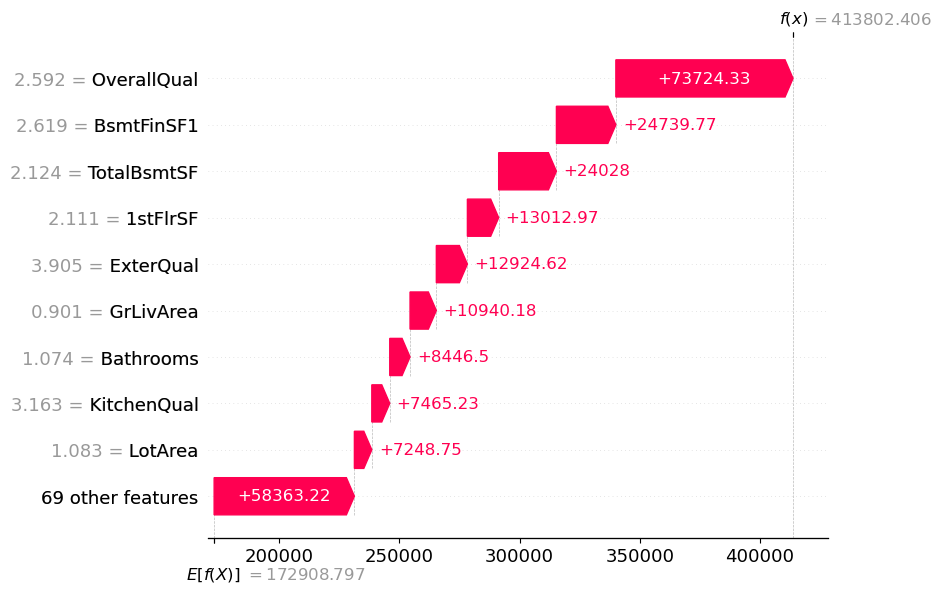

In [243]:
# quality of 9
shap.waterfall_plot(exp[9])

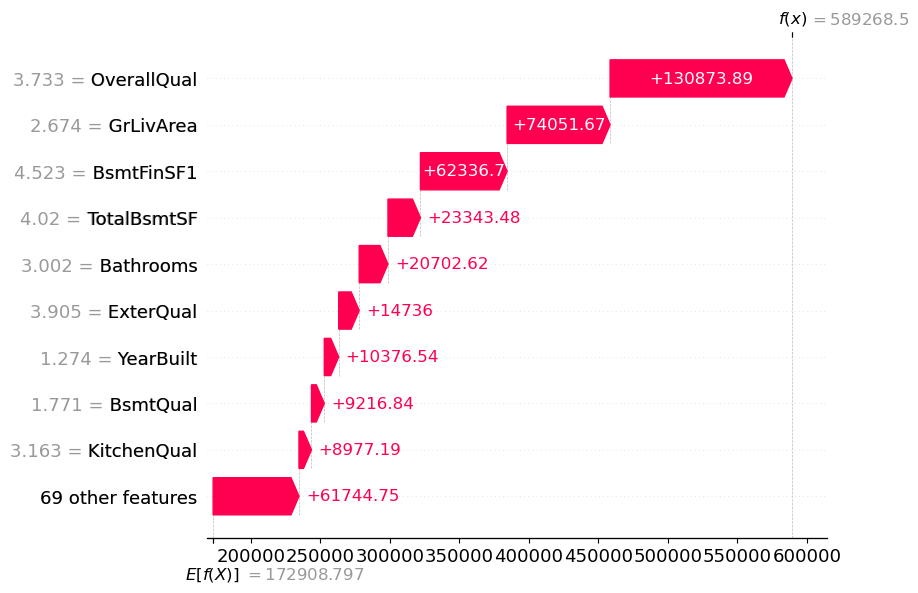

In [244]:
# Quality of 10
shap.waterfall_plot(exp[15])

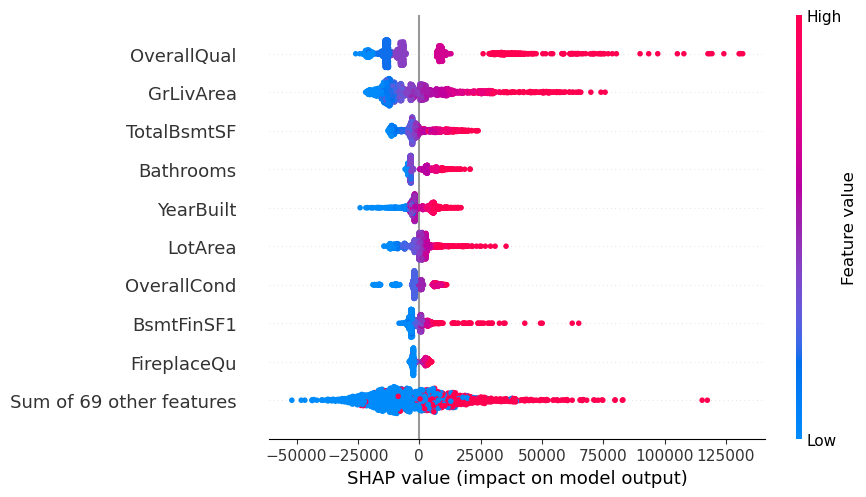

In [257]:
shap.plots.beeswarm(exp)

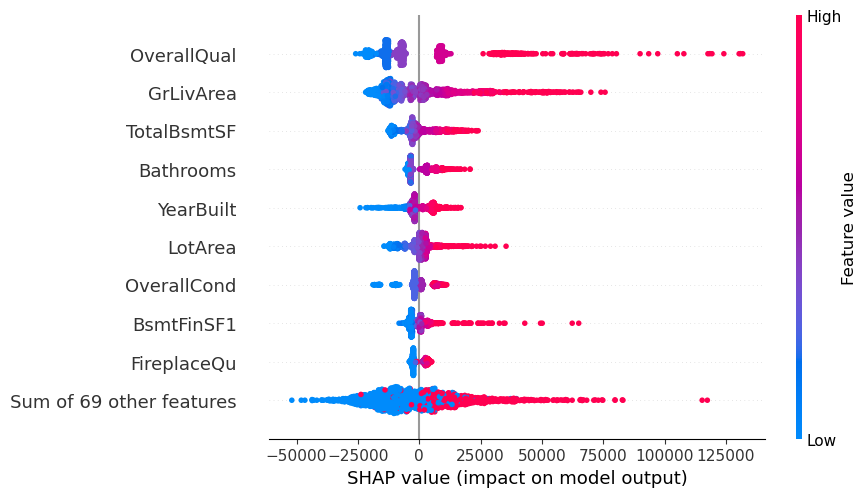

In [258]:
shap.plots.beeswarm(sv)

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

numerical_preprocessor = RobustScaler()


preprocessor = ColumnTransformer(
    [
        ("standard_scaler", numerical_preprocessor, numerical_columns),
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
    ]
)

lasso = Lasso(alpha= 0.0003061900989342117)

lasso_pipe = Pipeline(steps=[("Preprocess", preprocessor), ("Lasso", lasso)])

lasso_regr = TransformedTargetRegressor(regressor= lasso_pipe,
                                                func=np.log, inverse_func=np.exp)

In [5]:
lasso_pipe.fit(X,y)

Pipeline(steps=[('Preprocess',
                 ColumnTransformer(transformers=[('standard_scaler',
                                                  RobustScaler(),
                                                  ['GrLivArea', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LandSlope', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'ExterQual', 'ExterCond',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1', 'Bs...
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MSZoning', 'Street',
                                                   'LotConfig', 'Neighborhood',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'Foundation',
                                                   'Heating', 'CentralAir',
                                                   'Electrical', 'GarageType',
                                                   'GarageYN', 'PoolYN',
                                                   'Fence', 'SaleType',
                                                   'SaleCondition'])])),
                ('Lasso', Lasso(alpha=0.0003061900989342117))])

In [6]:
explainer = shap.Explainer(lasso_pipe['Lasso'])
data_transformation = lasso_pipe['Preprocess'].transform(X)
shap_values = explainer(data_transformation)

shap.plots.waterfall(shap_values[0])

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: Lasso(alpha=0.0003061900989342117)

In [22]:
lasso_scores = cross_val_score(lasso_regr, X, y, cv = kf, error_score='raise')
lasso_scores.mean()

0.9508125946535184

In [ ]:
e

In [23]:
ridge = Ridge(alpha=19.535539796579627)

ridge_pipe = Pipeline(steps=[("Preprocess", preprocessor), ("Ridge", ridge)])

ridge_regr = TransformedTargetRegressor(regressor= ridge_pipe,
                                                func=np.log, inverse_func=np.exp)


In [24]:
ridge_scores = cross_val_score(ridge_regr, X, y, cv = kf, error_score='raise')
ridge_scores.mean()

0.95003638254706

In [261]:
numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")               

numerical_preprocessor = RobustScaler()


preprocessor = ColumnTransformer(
    [
        ("robust_scaler", numerical_preprocessor, numerical_columns),
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
    ]
)

lasso = Lasso(alpha = 0.00030615490713200075)

lasso_pipe = Pipeline(steps=[("Preprocess", preprocessor), ("Lasso", lasso)])


lasso_regr = TransformedTargetRegressor(regressor= lasso_pipe,
                                                func=np.log, inverse_func=np.exp)

scores = cross_val_score(lasso_regr, X, y, cv = kf, error_score='raise')

scores.mean()

0.9508125912427354

# Lasso with chatGBT

In [298]:
lasso_regr.fit(X, y)

# Create a SHAP explainer for the Lasso model
explainer = shap.Explainer(lasso_regr.regressor_.named_steps['Lasso'], 
                           lasso_regr.regressor_.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values = explainer(lasso_regr.regressor_.named_steps['Preprocess'].transform(X))


In [305]:
transformed_predictions = lasso_regr.regressor_.predict(lasso_regr.regressor_.named_steps['Preprocess'].transform(X))

adjustment_factors = np.exp(transformed_predictions) / np.exp(lasso_regr.regressor_.predict(lasso_regr.regressor_.named_steps['Preprocess'].transform(X)).mean())

# Adjust SHAP values to reflect original target scale
shap_values.values *= adjustment_factors[:, np.newaxis]

ValueError: X has 216 features, but ColumnTransformer is expecting 78 features as input.

In [263]:
# Get feature names after transformation
transformed_feature_names = lasso_regr.regressor_.named_steps['Preprocess'].get_feature_names_out()

In [270]:
type(shap_values)

shap._explanation.Explanation

In [288]:
# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df = pd.DataFrame(shap_values.values, columns=transformed_feature_names)
# this are the values of X after preprocessing 
X_transformed_df = pd.DataFrame(lasso_regr.regressor_.named_steps['Preprocess'].transform(X), columns=transformed_feature_names)


In [289]:
shap_values_df

,robust_scaler__GrLivArea,robust_scaler__MSSubClass,robust_scaler__LotFrontage,robust_scaler__LotArea,robust_scaler__Alley,robust_scaler__LotShape,robust_scaler__LandContour,robust_scaler__Utilities,robust_scaler__LandSlope,robust_scaler__OverallQual,...,one-hot-encoder__SaleType_COD,one-hot-encoder__SaleType_CWD,one-hot-encoder__SaleType_Con,one-hot-encoder__SaleType_ConLD,one-hot-encoder__SaleType_ConLI,one-hot-encoder__SaleType_ConLw,one-hot-encoder__SaleType_Oth,one-hot-encoder__SaleType_VWD,one-hot-encoder__SaleType_WD,one-hot-encoder__SaleCondition_Normal
0,-0.140630,0.0,0.003895,-0.014793,-0.000105,-0.000445,-0.000038,0.0,-0.0,0.004220,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
1,-0.089829,-0.0,0.010062,-0.036492,-0.000105,-0.000445,-0.000038,0.0,-0.0,-0.047939,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2,-0.102464,0.0,0.004640,-0.025658,-0.000105,-0.000445,-0.000038,0.0,-0.0,-0.047939,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
3,-0.092462,-0.0,-0.001384,-0.013273,-0.000105,-0.000445,-0.000038,0.0,-0.0,-0.090615,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
4,0.072310,-0.0,0.001628,-0.011766,-0.000105,-0.000445,-0.000038,0.0,-0.0,0.136990,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,-0.115361,0.0,0.001596,-0.009070,-0.000105,-0.000445,-0.000038,0.0,-0.0,0.004220,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2329,0.090208,0.0,-0.009913,0.019581,-0.000105,0.000590,-0.000038,0.0,-0.0,-0.123808,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2330,0.161013,-0.0,-0.001986,-0.024411,-0.000105,-0.000445,0.000723,0.0,-0.0,-0.047939,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2331,0.118899,-0.0,0.001663,-0.009236,-0.000105,-0.000445,-0.000038,0.0,-0.0,0.065863,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0


In [290]:
# Identify original categorical features' prefixes in transformed data
categorical_prefixes = categorical_columns_selector(X)
categorical_prefixes = ["one-hot-encoder__" + word for word in categorical_prefixes]
categorical_prefixes

['one-hot-encoder__MSZoning',
 'one-hot-encoder__Street',
 'one-hot-encoder__LotConfig',
 'one-hot-encoder__Neighborhood',
 'one-hot-encoder__Condition1',
 'one-hot-encoder__Condition2',
 'one-hot-encoder__BldgType',
 'one-hot-encoder__HouseStyle',
 'one-hot-encoder__RoofStyle',
 'one-hot-encoder__RoofMatl',
 'one-hot-encoder__Exterior1st',
 'one-hot-encoder__Exterior2nd',
 'one-hot-encoder__MasVnrType',
 'one-hot-encoder__Foundation',
 'one-hot-encoder__Heating',
 'one-hot-encoder__CentralAir',
 'one-hot-encoder__Electrical',
 'one-hot-encoder__GarageType',
 'one-hot-encoder__GarageYN',
 'one-hot-encoder__PoolYN',
 'one-hot-encoder__Fence',
 'one-hot-encoder__SaleType',
 'one-hot-encoder__SaleCondition']

In [291]:
# Aggregate SHAP values for each categorical feature
for prefix in categorical_prefixes:
    # Get columns that start with the prefix
    columns = [col for col in transformed_feature_names if col.startswith(prefix)]
    
    # Calculate mean SHAP value for these columns
    shap_values_df[prefix] = shap_values_df[columns].mean(axis=1)
    
    # Drop the individual encoded columns
    shap_values_df.drop(columns=columns, inplace=True)
    
    # Update the transformed data DataFrame similarly
    X_transformed_df[prefix] = X_transformed_df[columns].mean(axis=1)
    X_transformed_df.drop(columns=columns, inplace=True)

# Now shap_values_df contains SHAP values with aggregated categorical feature contributions

In [294]:
shap_values_df

,robust_scaler__GrLivArea,robust_scaler__MSSubClass,robust_scaler__LotFrontage,robust_scaler__LotArea,robust_scaler__Alley,robust_scaler__LotShape,robust_scaler__LandContour,robust_scaler__Utilities,robust_scaler__LandSlope,robust_scaler__OverallQual,...,one-hot-encoder__Foundation,one-hot-encoder__Heating,one-hot-encoder__CentralAir,one-hot-encoder__Electrical,one-hot-encoder__GarageType,one-hot-encoder__GarageYN,one-hot-encoder__PoolYN,one-hot-encoder__Fence,one-hot-encoder__SaleType,one-hot-encoder__SaleCondition
0,-0.140630,0.0,0.003895,-0.014793,-0.000105,-0.000445,-0.000038,0.0,-0.0,0.004220,...,-0.001148,0.0,0.001343,0.0,-0.000787,0.0,0.0,0.000066,0.0,0.0
1,-0.089829,-0.0,0.010062,-0.036492,-0.000105,-0.000445,-0.000038,0.0,-0.0,-0.047939,...,-0.001148,0.0,0.001343,0.0,0.000503,0.0,0.0,0.000066,0.0,0.0
2,-0.102464,0.0,0.004640,-0.025658,-0.000105,-0.000445,-0.000038,0.0,-0.0,-0.047939,...,-0.002105,0.0,0.001343,0.0,-0.000787,0.0,0.0,0.000066,0.0,0.0
3,-0.092462,-0.0,-0.001384,-0.013273,-0.000105,-0.000445,-0.000038,0.0,-0.0,-0.090615,...,-0.002105,0.0,0.001343,0.0,-0.000787,0.0,0.0,0.000066,0.0,0.0
4,0.072310,-0.0,0.001628,-0.011766,-0.000105,-0.000445,-0.000038,0.0,-0.0,0.136990,...,0.001885,0.0,0.001343,0.0,0.000503,0.0,0.0,0.000066,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,-0.115361,0.0,0.001596,-0.009070,-0.000105,-0.000445,-0.000038,0.0,-0.0,0.004220,...,-0.002105,0.0,-0.017838,0.0,-0.000787,0.0,0.0,0.000066,0.0,0.0
2329,0.090208,0.0,-0.009913,0.019581,-0.000105,0.000590,-0.000038,0.0,-0.0,-0.123808,...,-0.001148,0.0,0.001343,0.0,0.000503,0.0,0.0,0.000066,0.0,0.0
2330,0.161013,-0.0,-0.001986,-0.024411,-0.000105,-0.000445,0.000723,0.0,-0.0,-0.047939,...,-0.001148,0.0,-0.017838,0.0,-0.000787,0.0,0.0,0.000066,0.0,0.0
2331,0.118899,-0.0,0.001663,-0.009236,-0.000105,-0.000445,-0.000038,0.0,-0.0,0.065863,...,0.001885,0.0,0.001343,0.0,0.000503,0.0,0.0,0.000066,0.0,0.0


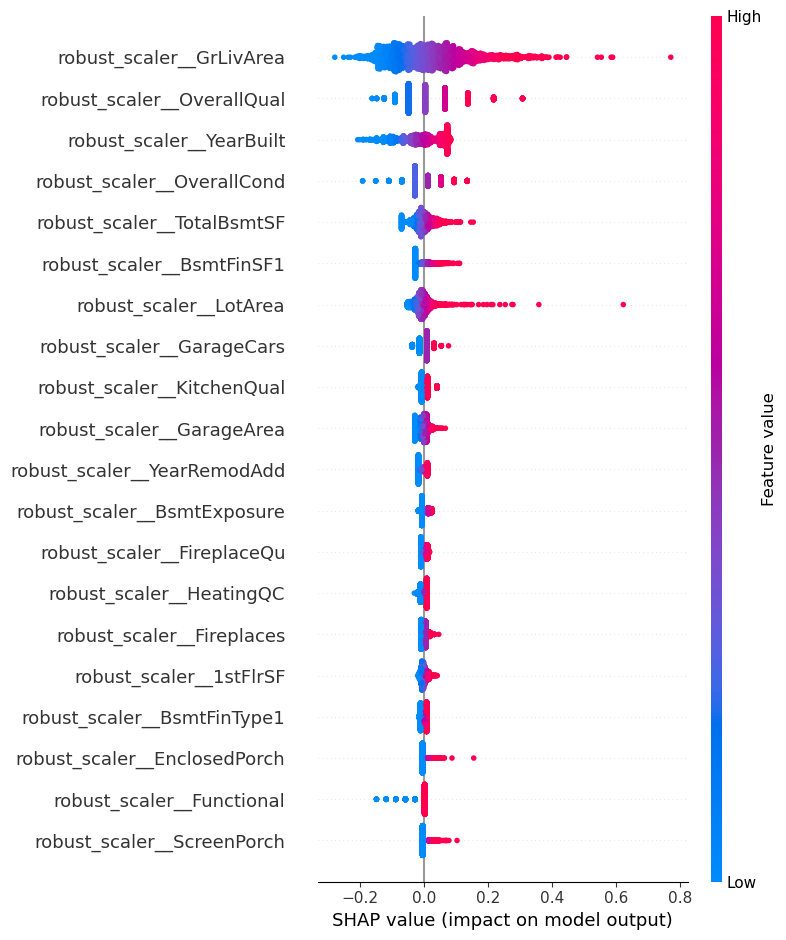

In [297]:
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values_df.iloc[0].values, 
                X_transformed_df.iloc[0].values)

# Summary plot
shap.summary_plot(shap_values_df.values, 
                  X_transformed_df.values, feature_names=shap_values_df.columns)